In [21]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'
import sys
sys.path.append('/home/chuikova/chuikova2/lib/python2.7/site-packages/')
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import time

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [3]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [4]:
# pre and post processing for images
img_size = 270 # to change
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/home/chuikova/chuikova2/lib/python2.7/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [5]:
torch.cuda.set_device(0)

In [6]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [10]:
name_left = '0134l.png'
name_right = '0134r.png'

In [47]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir, image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'face2.jpg', name_right, name_left] 
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image_1,style_image_2, content_image_r, content_image_l = imgs_torch

In [48]:
# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)

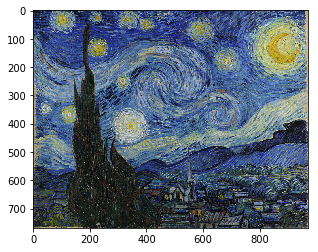

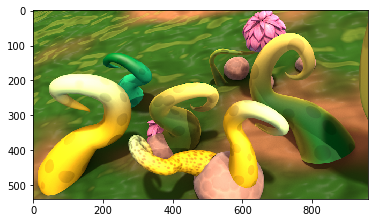

In [49]:
#display images
for img in imgs:
    imshow(img);show()

In [50]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets_1 = [GramMatrix()(A).detach() for A in vgg(style_image_1, style_layers)]
style_targets_2 = [GramMatrix()(A).detach() for A in vgg(style_image_2, style_layers)]

content_targets_r = [A.detach() for A in vgg(content_image_r, content_layers)]
content_targets_l = [A.detach() for A in vgg(content_image_l, content_layers)]
targets_r_1 = style_targets_1 +  content_targets_r
targets_l_1 = style_targets_1 + content_targets_l

targets_r_2 = style_targets_2 +  content_targets_r
targets_l_2 = style_targets_2 + content_targets_l

In [51]:
import cv2
import imageio
imgL = cv2.imread("Images/" + name_left, 0)
imgR = cv2.imread('Images/' + name_right, 0)
imgL = cv2.resize(imgL, (480, 270))
imgR = cv2.resize(imgR, (480, 270))

In [52]:
m_v = np.loadtxt('134vertical.txt').astype(int)
m_h = np.loadtxt('134horisontal.txt').astype(int)

new_image = np.zeros_like(imgL)
m, n = m_v.shape

x = np.arange(0, n)
y = np.arange(0, m)
xx, yy = np.meshgrid(x, y)
i, j = np.array(xx, dtype = int), np.array(yy, dtype = int)
opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)
optimizer = optim.LBFGS([opt_img_r, opt_img_l], max_iter = 20)

grid = np.expand_dims(np.stack([i+m_v,j+m_h], axis = 2),0)
grid_scaled = np.zeros_like(grid, dtype=np.float64)
grid_scaled[:,:,:,0] = (-1. + 2.*(grid[:,:,:,0] - grid[:,:,:,0].min())/(grid[:,:,:,0].max() - grid[:,:,:,0].min()))
grid_scaled[:,:,:,1] = (-1. + 2.*(grid[:,:,:,1] - grid[:,:,:,1].min())/(grid[:,:,:,1].max() - grid[:,:,:,1].min()))
grid_scaled = Variable(torch.FloatTensor(grid_scaled), requires_grad=False).cuda()
m_v_var = Variable(torch.from_numpy((m_v>0).astype(np.float32)), requires_grad=False).cuda()
new_image = F.grid_sample(opt_img_l, grid_scaled)
out_img = postp(new_image.data[0].cpu().squeeze())
imshow(out_img)

Iteration: 100, loss: 911105856.000000
('Loss on disp:', 14517472.0)
Time: 0.1
Iteration: 200, loss: 905663744.000000
('Loss on disp:', 2486714.0)
Time: 0.1
Iteration: 300, loss: 904604864.000000
('Loss on disp:', 813007.62)
Time: 0.1
Iteration: 400, loss: 904232256.000000
('Loss on disp:', 444661.44)
Time: 0.1
Iteration: 500, loss: 904039808.000000
('Loss on disp:', 294918.88)
Time: 0.1


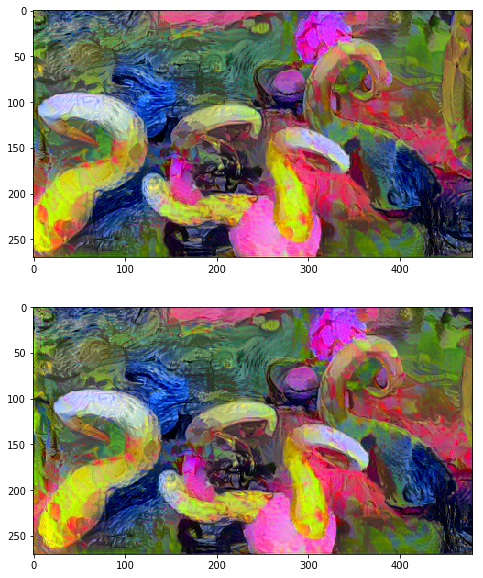

In [53]:
max_iter = 500 # 500
show_iter = 100 # 50
n_iter=[0]
s = opt_img_r.size()

while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        loss = 0
        layer_losses = [weights[a] * loss_fns[a](A, targets_r_1[a]) for a,A in enumerate(out_r)]
        loss = 0.5*sum(layer_losses)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r_2[a]) for a,A in enumerate(out_r)]
        loss += 0.5*sum(layer_losses)
        
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l_1[a]) for a,A in enumerate(out_l)]
        loss += 0.5*sum(layer_losses)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l_2[a]) for a,A in enumerate(out_l)]
        loss += 0.5*sum(layer_losses)
        
        new_image = F.grid_sample(opt_img_l, grid_scaled)
        loss_disp = ((m_v_var*(opt_img_r-new_image))**2).sum() 
        loss += 0.05*loss_disp  
        
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Loss on disp:', loss_disp.data.cpu().numpy()[0])
            print('Time: %.1f' % ((time.time()- begin)))
        return loss
    
    optimizer.step(closure)
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [54]:
img_styled = postp(opt_img_r.data[0].cpu().squeeze())
img_styled.save('Images/final/double_gogh_face_deep_134_r.png')
img_styled = postp(opt_img_l.data[0].cpu().squeeze())
img_styled.save('Images/final/double_gogh_face_deep_134_l.png')

Iteration: 100, loss: 211733008.000000
('Loss on disp:', 7493551.0)
Time: 0.1
Iteration: 200, loss: 208456544.000000
('Loss on disp:', 1743385.5)
Time: 0.1
Iteration: 300, loss: 207531584.000000
('Loss on disp:', 849296.88)
Time: 0.1
Iteration: 400, loss: 207093744.000000
('Loss on disp:', 547889.31)
Time: 0.1
Iteration: 500, loss: 206843968.000000
('Loss on disp:', 379370.91)
Time: 0.1


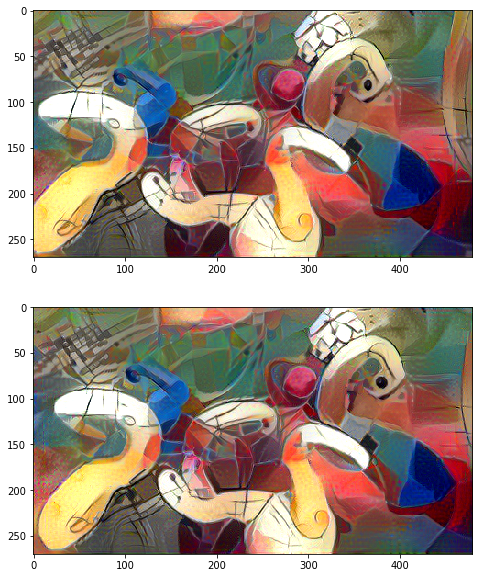

In [45]:
max_iter = 500 # 500
show_iter = 100 # 50
n_iter=[0]
s = opt_img_r.size()

while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        loss = 0
        layer_losses = [weights[a] * loss_fns[a](A, targets_r_1[a]) for a,A in enumerate(out_r)]
        loss = 0.5*sum(layer_losses)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r_2[a]) for a,A in enumerate(out_r)]
        loss += 0.5*sum(layer_losses)
        
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l_1[a]) for a,A in enumerate(out_l)]
        loss += 0.5*sum(layer_losses)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l_2[a]) for a,A in enumerate(out_l)]
        loss += 0.5*sum(layer_losses)
        
        new_image = F.grid_sample(opt_img_l, grid_scaled)
        loss_disp = ((m_v_var*(opt_img_r-new_image))**2).sum() 
        loss += 0.05*loss_disp  
        
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Loss on disp:', loss_disp.data.cpu().numpy()[0])
            print('Time: %.1f' % ((time.time()- begin)))
        return loss
    
    optimizer.step(closure)
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [46]:
img_styled = postp(opt_img_r.data[0].cpu().squeeze())
img_styled.save('Images/final/double_cube_abst_deep_134_r.png')
img_styled = postp(opt_img_l.data[0].cpu().squeeze())
img_styled.save('Images/final/double_cube_abst_deep_134_l.png')

Iteration: 98, loss: 910507456.000000
Time: 0.2
('Disparity loss: ', 91318576.0)
Iteration: 198, loss: 905680640.000000
Time: 0.2
('Disparity loss: ', 10612676.0)
Iteration: 298, loss: 904675072.000000
Time: 0.2
('Disparity loss: ', 3791968.8)
Iteration: 398, loss: 904240768.000000
Time: 0.2
('Disparity loss: ', 2045066.4)
Iteration: 498, loss: 904012928.000000
Time: 0.2
('Disparity loss: ', 1227230.5)


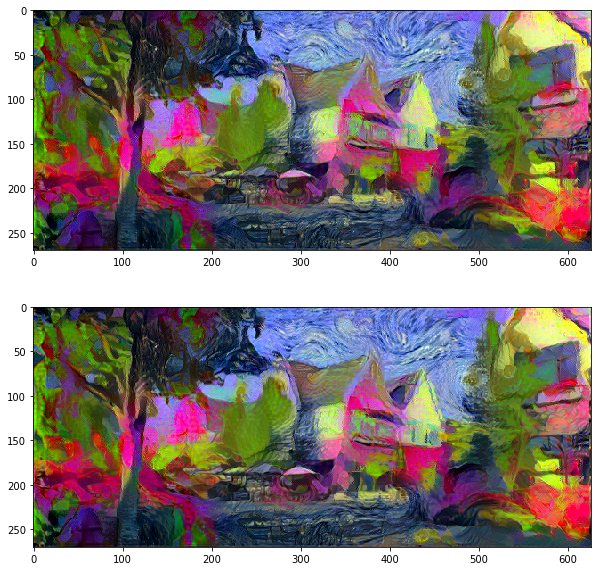

In [26]:
opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)

new_image = np.zeros_like(imgL)
m, n = disparity.shape

x = np.arange(0, m)
y = np.arange(0, n)
xx, yy = np.meshgrid(x, y)
i, j = np.array(xx, dtype = int), np.array(yy, dtype = int)

i = i.transpose(1,0)
j = j.transpose(1,0)
grid = np.expand_dims(np.stack([(j-disparity[i, j]//16),i], axis = 2),0)
grid_scaled = np.zeros_like(grid, dtype=np.float64)
grid_scaled[:,:,:,0] = (-1. + 2.*(grid[:,:,:,0] - grid[:,:,:,0].min())/(grid[:,:,:,0].max() - grid[:,:,:,0].min()))
grid_scaled[:,:,:,1] = (-1. + 2.*(grid[:,:,:,1] - grid[:,:,:,1].min())/(grid[:,:,:,1].max() - grid[:,:,:,1].min()))

#run style transfer
max_iter = 500 # 500
show_iter = 100 # 50
optimizer = optim.LBFGS([opt_img_r, opt_img_l], max_iter=1);
n_iter=[0]
#n = 0
s = opt_img_r.size()

while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        loss = 0
        layer_losses = [weights[a] * loss_fns[a](A, targets_r_1[a]) for a,A in enumerate(out_r)]
        loss = 0.5*sum(layer_losses)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r_2[a]) for a,A in enumerate(out_r)]
        loss += 0.5*sum(layer_losses)
        
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l_1[a]) for a,A in enumerate(out_l)]
        loss += 0.5*sum(layer_losses)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l_2[a]) for a,A in enumerate(out_l)]
        loss += 0.5*sum(layer_losses)
        
        new_image = F.grid_sample(opt_img_r, Variable(torch.FloatTensor(grid_scaled)).cuda())
        
        loss_disp = (((opt_img_l[:,:,:,17:]-new_image[:,:,:,17:]))**2).sum() 
        loss += 2*2*0.005*loss_disp
        loss.backward()
        n_iter[0]+=1
        #print loss
        if (n_iter[0]+1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Time: %.1f' % ((time.time()- begin)))
            print('Disparity loss: ', loss_disp.data.cpu().numpy()[0])
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    #n += 1
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [35]:
opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)

new_image = np.zeros_like(imgL)
m, n = disparity.shape

x = np.arange(0, m)
y = np.arange(0, n)
xx, yy = np.meshgrid(x, y)
i, j = np.array(xx, dtype = int), np.array(yy, dtype = int)

i = i.transpose(1,0)
j = j.transpose(1,0)
grid = np.expand_dims(np.stack([(j-disparity[i, j]//16),i], axis = 2),0)
grid_scaled = np.zeros_like(grid, dtype=np.float64)
grid_scaled[:,:,:,0] = (-1. + 2.*(grid[:,:,:,0] - grid[:,:,:,0].min())/(grid[:,:,:,0].max() - grid[:,:,:,0].min()))
grid_scaled[:,:,:,1] = (-1. + 2.*(grid[:,:,:,1] - grid[:,:,:,1].min())/(grid[:,:,:,1].max() - grid[:,:,:,1].min()))

#run style transfer
max_iter = 500 # 500
show_iter = 100 # 50
optimizer = optim.LBFGS([opt_img_r, opt_img_l], max_iter=1);
n_iter=[0]
#n = 0
s = opt_img_r.size()

while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        loss = 0
        layer_losses = [weights[a] * loss_fns[a](A, targets_r_1[a]) for a,A in enumerate(out_r)]
        loss = 0.5*sum(layer_losses)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r_2[a]) for a,A in enumerate(out_r)]
        loss += 0.5*sum(layer_losses)
        
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l_1[a]) for a,A in enumerate(out_l)]
        loss += 0.5*sum(layer_losses)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l_2[a]) for a,A in enumerate(out_l)]
        loss += 0.5*sum(layer_losses)
        
        new_image = F.grid_sample(opt_img_r, Variable(torch.FloatTensor(grid_scaled)).cuda())
        
        loss_disp = (((opt_img_l[:,:,:,17:]-new_image[:,:,:,17:]))**2).sum() 
        loss += 100*10*0.005*loss_disp
        loss.backward()
        n_iter[0]+=1
        #print loss
        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Time: %.1f' % ((time.time()- begin)))
            print('Disparity loss: ', loss_disp.data.cpu().numpy()[0])
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    #n += 1
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

Iteration: 98, loss: 908585152.000000
Time: 0.2
('Disparity loss: ', 20427.502)
Iteration: 198, loss: 905465216.000000
Time: 0.2
('Disparity loss: ', 2498.9438)
Iteration: 298, loss: 904634752.000000
Time: 0.2
('Disparity loss: ', 818.92285)
Iteration: 398, loss: 904251520.000000
Time: 0.2
('Disparity loss: ', 445.36743)
Iteration: 498, loss: 904045888.000000
Time: 0.2
('Disparity loss: ', 274.65225)


In [36]:
img_styled = postp(opt_img_r.data[0].cpu().squeeze())
img_styled.save('Images/house_double4_styled_r.png')
img_styled = postp(opt_img_l.data[0].cpu().squeeze())
img_styled.save('Images/house_double4_styled_l.png')